<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/02_short_term_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio -- ***15% of Complete Portfolio***
The goal is to select the top stocks based on sentiment analysis and technical indicators while adhering to portfolio constraints and avoiding overfitting.

### Step 1: Import Libraries

In [1]:
# System libraries
import glob
import os
import sys
import logging
import warnings
from io import StringIO
from typing import Dict, List
from dotenv import load_dotenv

# Data manipulation libraries
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Backtesting library
import bt

# Suppress warnings and logging
warnings.filterwarnings('ignore')
os.environ['YFINANCE_PROGRESS'] = 'False'
logging.getLogger('bt').setLevel(logging.CRITICAL)
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

# Load environment variables
load_dotenv()

True

### Step 2: Define Parameters

#### Date Range

In [2]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=10*365)            

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2015-06-14 to 2025-06-11
Time span: 3650 days (10.00 years)


#### Risk-free rate (T-bill, %)

In [3]:
from py.utils import load_and_filter_data

daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.0424 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio File

In [4]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-06-10.xlsx


### Step 3: Import News Data (FMP API)
- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [5]:
from py.fetch_fmp_api import create_session, fetch_data

# Get API key from environment variables
FMP_API_KEY = os.getenv('FMP_API_KEY')
if not FMP_API_KEY:
    raise ValueError("FMP_API_KEY not found in environment variables")

# Create session and fetch data
session = create_session()
data = fetch_data(
    api_key=FMP_API_KEY,
    session=session,
    days_back=30,           # 30 days back
    max_pages=15,           # 15 pages
    records_per_page=1000,  
    request_timeout=10      
)

news_df = pl.DataFrame(data)
display(news_df.sort('publishedDate', descending=True).head())

Fetching page 1/15...
Page 1: 1000 articles fetched
Fetching page 2/15...
Page 2: 1000 articles fetched
Fetching page 3/15...
Page 3: 999 articles fetched
Fetching page 4/15...
Page 4: 1000 articles fetched
Fetching page 5/15...
Page 5: 1000 articles fetched
Fetching page 6/15...
Page 6: 1000 articles fetched
Fetching page 7/15...
Page 7: 1000 articles fetched
Fetching page 8/15...
Page 8: 1000 articles fetched
Fetching page 9/15...
Page 9: 1000 articles fetched
Fetching page 10/15...
Page 10: 1000 articles fetched
Fetching page 11/15...
Page 11: 1000 articles fetched
Fetching page 12/15...
Page 12: 1000 articles fetched
Fetching page 13/15...
Page 13: 1000 articles fetched
Fetching page 14/15...
Page 14: 1000 articles fetched
Fetching page 15/15...
Page 15: 1000 articles fetched
Total articles fetched: 14999


symbol,publishedDate,title,image,site,text,url
str,str,str,str,str,str,str
"""ORCL""","""2025-06-12 11:46:08""","""Oracle Stock Jumps on Q4 Earni…","""https://images.financialmodeli…","""zacks.com""","""ORCL's fiscal fourth-quarter r…","""https://www.zacks.com/stock/ne…"
"""FIX""","""2025-06-12 11:46:04""","""Comfort Systems Stock Rises 52…","""https://images.financialmodeli…","""zacks.com""","""Comfort Systems USA FIX has de…","""https://www.zacks.com/stock/ne…"
"""SCA""","""2025-06-12 11:45:00""","""TOUAX SCA's Combined General M…","""https://images.financialmodeli…","""globenewswire.com""","""PRESS RELEASE Paris, Ju…","""https://www.globenewswire.com/…"
"""CRARY""","""2025-06-12 11:45:00""","""Credit Agricole Sa: Crédit Agr…","""https://images.financialmodeli…","""globenewswire.com""","""Press release …","""https://www.globenewswire.com/…"
"""OKE""","""2025-06-12 11:42:45""","""The Market Has Yet To Price In…","""https://images.financialmodeli…","""seekingalpha.com""","""ONEOK's diversified midstream …","""https://seekingalpha.com/artic…"


### Step 4: Sentiment Analysis
- Use `TextBlob` for sentiment analysis on news headlines.

In [6]:
from py.sentiment_analysis import calculate_stock_sentiment_metrics, get_fundamental_value, calculate_sector_averages

# Load fundamental data and prepare ticker lists
print("Loading fundamental data...")
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
fundamentals_pandas = fundamentals_df.to_pandas().set_index('Ticker')
all_tickers = set(news_df['symbol'].to_list() + fundamentals_df['Ticker'].to_list())
EXCLUDED_SYMBOLS = {'AI', 'S', 'A', 'U', 'E', 'US', 'ET', 'TSXV', 'CODI', 'C'}

print(f"Loaded {len(fundamentals_df)} stocks, {len(all_tickers)} unique tickers")

# Execute sentiment analysis
print("Analyzing sentiment for stock symbols...")
sentiment_metrics = calculate_stock_sentiment_metrics(news_df, all_tickers, EXCLUDED_SYMBOLS)
sentiment_df = pl.DataFrame([{
    "symbol": symbol, "articlesInLastWeek": metrics["articlesInLastWeek"],
    "companyNewsScore": metrics["companyNewsScore"], 
    "bearishPercent": metrics["sentiment"]["bearishPercent"],
    "bullishPercent": metrics["sentiment"]["bullishPercent"],
    "averageSentimentScore": metrics["averageSentimentScore"],
    "totalArticles": metrics["totalArticles"]
} for symbol, metrics in sentiment_metrics.items()]).sort(["articlesInLastWeek", "companyNewsScore"], descending=[True, True])

# Add fundamental data and sector averages
sector_averages = calculate_sector_averages(sentiment_df, fundamentals_pandas)
sentiment_with_fundamentals = sentiment_df.with_columns([
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageBullishPercent', 0), return_dtype=pl.Float64).alias("sectorAverageBullishPercent"),
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageNewsScore', 0), return_dtype=pl.Float64).alias("sectorAverageNewsScore"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Sector', 'Unknown'), return_dtype=pl.Utf8).alias("sector"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Market Cap'), return_dtype=pl.Float64).alias("marketCap"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'P/E (trailing)'), return_dtype=pl.Float64).alias("peRatio"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Price'), return_dtype=pl.Float64).alias("price")
])

# Screen stocks and analyze sectors
comprehensive_screened = sentiment_with_fundamentals.filter(
    (pl.col("articlesInLastWeek") >= 3) & 
    (pl.col("companyNewsScore") >= 0.45)
).sort(["companyNewsScore", "articlesInLastWeek"], descending=[True, True])

sector_summary = sentiment_with_fundamentals.filter(
    pl.col("sector") != "Unknown"
).group_by("sector").agg([
    pl.count("symbol").alias("stock_count"), 
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent"), 
    pl.mean("articlesInLastWeek").alias("avg_articles"),
    pl.mean("marketCap").alias("avg_market_cap"), 
    pl.mean("peRatio").alias("avg_pe_ratio")
]).sort("avg_news_score", descending=True)

print(f"\nScreened {len(comprehensive_screened)} stocks, {len(sector_averages)} sectors")
display(comprehensive_screened.head())
display(sector_summary)

Loading fundamental data...
Loaded 504 stocks, 4197 unique tickers
Analyzing sentiment for stock symbols...

Screened 1698 stocks, 11 sectors


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""DRTTF""",3,0.8965,0.0,1.0,0.7929,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""AZEK""",11,0.7749,0.0,1.0,0.5499,11,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""CARG""",4,0.7626,0.0,1.0,0.5251,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""ENGIY""",4,0.76,0.0,1.0,0.5201,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""PAG""",3,0.7523,0.0,1.0,0.5046,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0


sector,stock_count,avg_news_score,avg_bullish_percent,avg_articles,avg_market_cap,avg_pe_ratio
str,u32,f64,f64,f64,f64,f64
"""Real Estate""",24,0.594779,0.607362,8.125,3.9224e10,NaN
"""Consumer Cyclical""",43,0.577509,0.623051,15.27907,1.3467e11,32.916279
"""Consumer Defensive""",31,0.570971,0.536894,17.548387,1.0391e11,NaN
"""Technology""",75,0.56988,0.53128,17.933333,2.3076e11,NaN
"""Healthcare""",55,0.567215,0.471555,11.981818,9.0750e10,NaN
…,…,…,…,…,…,…
"""Industrials""",58,0.566831,0.511678,10.431034,6.5003e10,NaN
"""Communication Services""",20,0.56229,0.478585,22.85,3.9500e11,NaN
"""Financial Services""",55,0.56014,0.472551,14.781818,1.0748e11,NaN


### Step 5: Select Top 100 stocks ***(by `averageSentimentScore`)***
- Constrained by being part of the S&P 500 index and not already in the long-term portfolio.

In [7]:
# Load long-term portfolio and select top sentiment stocks
long_term_tickers = pl.read_excel(output_file, sheet_name='long_term_portfolio')['Ticker'].to_list()
print(f"Excluding {len(long_term_tickers)} tickers already in long-term portfolio: {long_term_tickers}")

selected_stocks = (comprehensive_screened
    .filter(pl.col("sector") != 'Unknown')
    .filter(~pl.col("symbol").is_in(long_term_tickers))
    .sort("averageSentimentScore", descending=True)
    .head(100))

screened_tickers = selected_stocks['symbol'].to_list()
print(f"\nSelected {len(screened_tickers)} stocks with highest sentiment scores")
display(selected_stocks.head())

# Sector distribution and summary statistics
sector_distribution = selected_stocks.group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("averageSentimentScore").alias("avg_sentiment_score"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent")
]).sort("stock_count", descending=True)

print(f"\nSector distribution:")
display(sector_distribution.head())

# Show summary statistics
print(f"\nSummary statistics for selected stocks:")
print(f"Average sentiment score: {selected_stocks['averageSentimentScore'].mean():.4f}")
print(f"Min sentiment score: {selected_stocks['averageSentimentScore'].min():.4f}")
print(f"Max sentiment score: {selected_stocks['averageSentimentScore'].max():.4f}")
print(f"Average company news score: {selected_stocks['companyNewsScore'].mean():.4f}")
print(f"Number of stocks: {selected_stocks['symbol'].count()}")
print(f"Number of unique sectors: {selected_stocks['sector'].n_unique()}")

Excluding 5 tickers already in long-term portfolio: ['MMC', 'AMAT', 'MRK', 'TMUS', 'APO']

Selected 100 stocks with highest sentiment scores


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""DTE""",11,0.7112,0.0,1.0,0.4225,11,0.4952,0.5669,"""Utilities""",2.8013e10,18.1,134.99
"""VRSK""",3,0.6833,0.0,1.0,0.3667,3,0.5117,0.5668,"""Industrials""",4.3683e10,46.06,312.28
"""USB""",5,0.6808,0.0,1.0,0.3617,5,0.4726,0.5601,"""Financial Services""",6.9402e10,10.94,44.54
"""PODD""",4,0.6805,0.0,0.75,0.361,4,0.4716,0.5672,"""Healthcare""",2.1261e10,55.53,302.1
"""ATO""",6,0.6782,0.0,0.6667,0.3563,6,0.4952,0.5669,"""Utilities""",2.4327e10,21.24,153.16



Sector distribution:


sector,stock_count,avg_sentiment_score,avg_news_score,avg_bullish_percent
str,u32,f64,f64,f64
"""Technology""",21,0.217967,0.60899,0.755019
"""Healthcare""",15,0.21988,0.609953,0.706787
"""Financial Services""",13,0.224023,0.612008,0.826677
"""Industrials""",11,0.2523,0.626145,0.748
"""Consumer Cyclical""",9,0.243111,0.621567,0.7932



Summary statistics for selected stocks:
Average sentiment score: 0.2288
Min sentiment score: 0.1676
Max sentiment score: 0.4225
Average company news score: 0.6144
Number of stocks: 100
Number of unique sectors: 11


### Step 6: Import Stock Quotes

In [8]:
quotes = load_and_filter_data('data/daily_stock_quotes.csv', screened_tickers, start_date, end_date)
quotes = quotes.dropna(axis=1, how='any').dropna(axis=0, how='any')
available_tickers = quotes.columns.tolist()

print(f"Available tickers after cleaning: {available_tickers}")
print(f"Dataset shape after cleaning: {quotes.shape}")
print(f"Date range: {quotes.index[0]} to {quotes.index[-1]}")
display(quotes.head())

Found 99 of 100 tickers in data/daily_stock_quotes.csv
Missing tickers: ['GEV']
Available tickers after cleaning: ['ABT', 'ACN', 'ADI', 'AES', 'ALB', 'ALL', 'AMP', 'ANSS', 'AON', 'APTV', 'ATO', 'AWK', 'AZO', 'BAC', 'BIIB', 'BK', 'BKNG', 'CAG', 'CDNS', 'CL', 'CLX', 'CMCSA', 'CME', 'CMS', 'CNC', 'COO', 'COP', 'COR', 'COST', 'CSCO', 'CTAS', 'CTSH', 'CVS', 'DOC', 'DTE', 'EMR', 'ESS', 'ETN', 'FI', 'FOX', 'FRT', 'FSLR', 'GEN', 'GOOGL', 'GPC', 'GRMN', 'HAL', 'HCA', 'HD', 'HII', 'HWM', 'IFF', 'INTU', 'ISRG', 'JNJ', 'KEYS', 'LDOS', 'MCHP', 'MCK', 'MCO', 'MMM', 'MOH', 'MOS', 'MSCI', 'MSFT', 'MTCH', 'NEE', 'NEM', 'NOW', 'NTAP', 'NXPI', 'OKE', 'PANW', 'PEG', 'PLD', 'PODD', 'RCL', 'RF', 'RTX', 'SLB', 'SNPS', 'STX', 'SYF', 'TJX', 'TSCO', 'UAL', 'ULTA', 'USB', 'VRSK', 'VRTX', 'VZ', 'WELL', 'WMT', 'WTW', 'ZTS']
Dataset shape after cleaning: (2512, 95)
Date range: 2015-06-15 00:00:00 to 2025-06-09 00:00:00


,ABT,ACN,ADI,AES,ALB,ALL,AMP,ANSS,AON,APTV,...,UAL,ULTA,USB,VRSK,VRTX,VZ,WELL,WMT,WTW,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-15,39.75,81.32,54.60,9.33,50.59,53.73,102.97,88.769997,93.31,66.97,...,52.250000,154.570000,31.33,71.00,123.495,28.14,45.35,19.82,107.89,45.70
2015-06-16,40.09,82.09,54.54,9.43,50.64,54.26,103.43,89.870000,94.04,67.25,...,51.230000,155.500000,31.47,71.22,123.340,28.39,45.67,19.93,108.21,46.11
2015-06-17,40.16,82.29,55.04,9.49,51.05,54.14,103.34,89.870000,94.36,68.15,...,51.320000,155.619995,31.50,71.86,124.045,28.30,45.82,20.04,108.46,46.53
2015-06-18,41.30,82.61,55.91,9.62,52.09,55.09,104.25,90.720000,95.09,68.31,...,52.009998,156.479996,31.60,72.37,127.630,28.60,46.26,20.11,109.14,46.84
2015-06-19,41.25,82.37,55.59,9.62,51.19,53.55,102.93,90.919998,93.70,68.39,...,53.250000,154.729996,31.50,72.30,128.040,28.41,46.17,20.04,108.12,46.60


### Step 7: Model Building & Validation

#### 1: Split Data into Training and Testing Sets

In [9]:
# Split data into 80% training and 20% testing based on date
total_rows = len(quotes)
train_size = int(0.8 * total_rows)
training_set = quotes.iloc[:train_size]
test_set = quotes.iloc[train_size:]

print(f"Training: {len(training_set)} rows ({len(training_set)/total_rows:.1%}) | Testing: {len(test_set)} rows ({len(test_set)/total_rows:.1%})")
print(f"Training period: {training_set.index[0]} to {training_set.index[-1]}")
print(f"Testing period: {test_set.index[0]} to {test_set.index[-1]}")

Training: 2009 rows (80.0%) | Testing: 503 rows (20.0%)
Training period: 2015-06-15 00:00:00 to 2023-06-06 00:00:00
Testing period: 2023-06-07 00:00:00 to 2025-06-09 00:00:00


#### 2: Find Optimal Strategy -- Training Set
- Backtest & Optimize Strategies (Loop through different parameters)
- Select Top Stocks ***(by Sharpe Ratio)***

In [10]:
max_stocks = 2

# Define custom parameter iterations
custom_parameter_iterations = [
    {'name': 'Aggressive', 'ranges': {'SMA_Cross_Signal': {'short_periods': [10, 15, 20], 'long_periods': [50, 75, 100]}, 'EMA_Cross_Signal': {'short_periods': [8, 12, 16], 'long_periods': [25, 35, 45]}}},
    {'name': 'Conservative', 'ranges': {'SMA_Cross_Signal': {'short_periods': [20, 30, 40, 50], 'long_periods': [100, 120, 140, 160]}, 'EMA_Cross_Signal': {'short_periods': [12, 20, 26], 'long_periods': [50, 60, 70]}}},
    {'name': 'Ultra-Conservative', 'ranges': {'SMA_Cross_Signal': {'short_periods': [20, 50], 'long_periods': [100, 150]}, 'EMA_Cross_Signal': {'short_periods': [12, 26], 'long_periods': [50, 70]}}}
]

🎯 ENHANCED STRATEGY SELECTION WITH STOCK ROTATION & OVERFITTING PROTECTION
📊 Available tickers: ['ABT', 'ACN', 'ADI', 'AES', 'ALB', 'ALL', 'AMP', 'ANSS', 'AON', 'APTV', 'ATO', 'AWK', 'AZO', 'BAC', 'BIIB', 'BK', 'BKNG', 'CAG', 'CDNS', 'CL', 'CLX', 'CMCSA', 'CME', 'CMS', 'CNC', 'COO', 'COP', 'COR', 'COST', 'CSCO', 'CTAS', 'CTSH', 'CVS', 'DOC', 'DTE', 'EMR', 'ESS', 'ETN', 'FI', 'FOX', 'FRT', 'FSLR', 'GEN', 'GOOGL', 'GPC', 'GRMN', 'HAL', 'HCA', 'HD', 'HII', 'HWM', 'IFF', 'INTU', 'ISRG', 'JNJ', 'KEYS', 'LDOS', 'MCHP', 'MCK', 'MCO', 'MMM', 'MOH', 'MOS', 'MSCI', 'MSFT', 'MTCH', 'NEE', 'NEM', 'NOW', 'NTAP', 'NXPI', 'OKE', 'PANW', 'PEG', 'PLD', 'PODD', 'RCL', 'RF', 'RTX', 'SLB', 'SNPS', 'STX', 'SYF', 'TJX', 'TSCO', 'UAL', 'ULTA', 'USB', 'VRSK', 'VRTX', 'VZ', 'WELL', 'WMT', 'WTW', 'ZTS']
Creating combinations of 2 stocks...
Testing 20 random combinations out of 4465 possible

🔄 STOCK COMBINATION 1/20: ['ATO', 'COST']
------------------------------------------------------------
  🔄 ITERATION 1: A

🔍 Running Overfitting Analysis...
📊 SUMMARY STATISTICS
Strategies tested: 2
In-sample mean Sharpe: 0.257
Out-sample mean Sharpe: 0.618
In-sample mean Sortino: 0.328
Out-sample mean Sortino: 0.858

📈 STATISTICAL TEST RESULTS
Sharpe t-statistic: -7.202
Sharpe p-value: 0.991
Sortino t-statistic: -14.543
Sortino p-value: 0.998

🎯 OVERFITTING STATUS: NOT DETECTED
   ✅ Sharpe ratio degradation not significant (p=0.991)
   ✅ Sortino ratio degradation not significant (p=0.998)

💡 RECOMMENDATIONS:
  ✅ NO SIGNIFICANT OVERFITTING: The strategy maintains reasonable performance from in-sample to out-of-sample testing.
  💡 Continue monitoring:
  • Track performance over time
  • Consider additional validation periods
  • Monitor parameter stability

📋 DETAILED TICKER ANALYSIS:

COST:
  In-sample Sharpe: 0.233
  Out-sample Sharpe: 0.663
  Degradation: -184.2%
  Strategy: EMA_Cross_Signal
  Periods: 8/25

ATO:
  In-sample Sharpe: 0.281
  Out-sample Sharpe: 0.574
  Degradation: -104.5%
  Strategy: SMA_

,Ticker,Strategy,Best_Sharpe,Best_Sortino,CAGR,Max_Drawdown,Volatility,Short_Period,Long_Period
0,CMCSA,SMA_Cross_Signal,0.372491,0.500460,0.064151,-0.368683,0.252966,20,120
1,HII,EMA_Cross_Signal,0.146231,0.205158,0.001362,-0.382451,0.282847,26,50


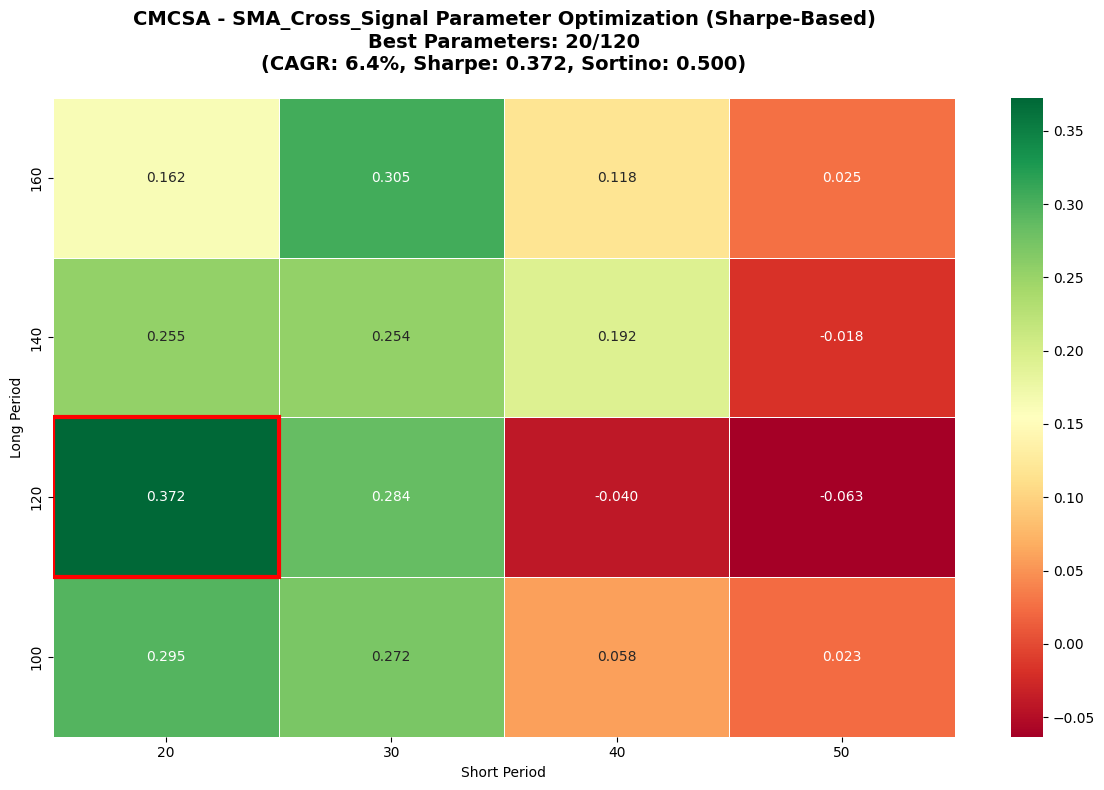

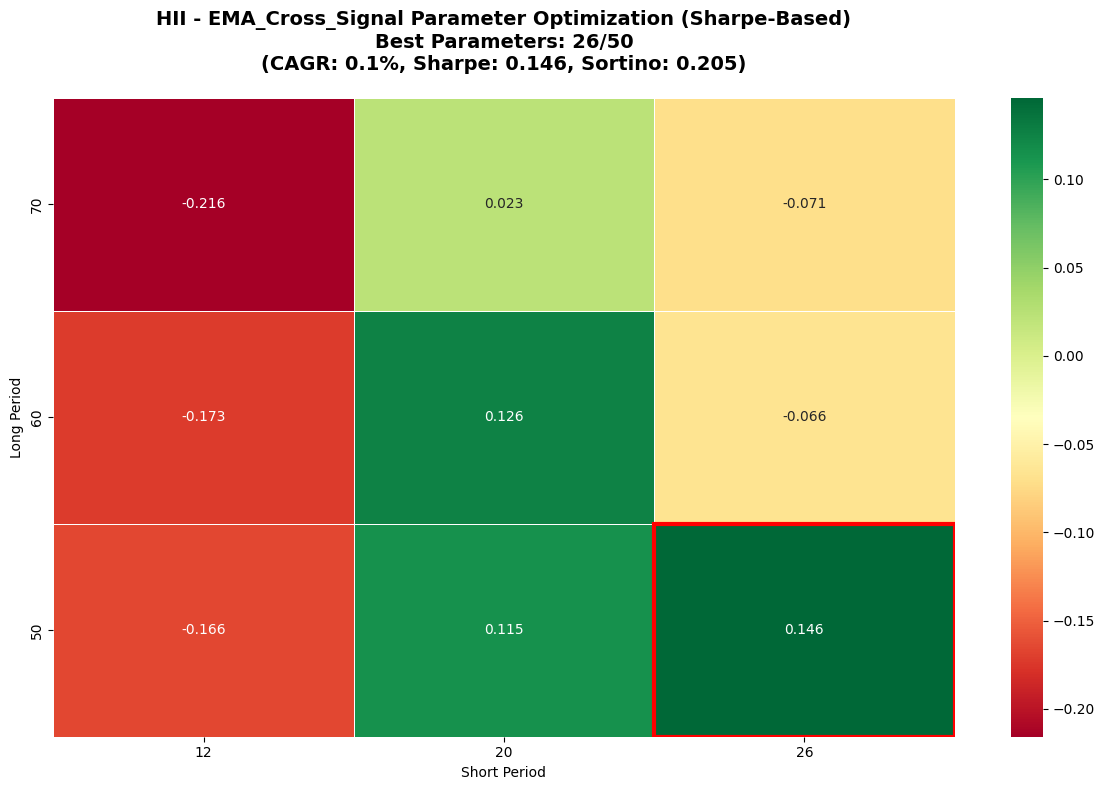


🎯 FINAL SELECTION: ['CMCSA', 'HII'] | Validation: ✅ PASSED


In [11]:
from py.technical_analysis import find_optimal_portfolio_with_parameter_optimization, find_robust_strategies_with_stock_rotation, walk_forward_validation, run_overfitting_analysis, plot_optimization_heatmaps

robust_strategy_results = find_robust_strategies_with_stock_rotation(quotes, available_tickers, max_iterations=4, target_stocks=max_stocks, parameter_iterations=custom_parameter_iterations)

if robust_strategy_results:
    optimization_results, overfitting_analysis, stability_ratio, validation_status, stock_combination = robust_strategy_results['optimization_results'], robust_strategy_results.get('overfitting_analysis'), robust_strategy_results.get('stability_ratio', 0.5), robust_strategy_results['validation_status'], robust_strategy_results['stock_combination']
    optimization_summary, portfolio_stats, selected_tickers = optimization_results['optimization_summary'], optimization_results.get('portfolio_stats', {}), optimization_results['selected_tickers']
    is_overfitted, sharpe_p_value = (overfitting_analysis['statistical_tests'].get('is_overfitted', False), overfitting_analysis['statistical_tests'].get('sharpe_p_value', 1.0)) if overfitting_analysis else (False, 0.1)
    print(f"\n✅ FINAL STRATEGY SELECTED:\nStock combination tested: {stock_combination}\nSelected tickers: {selected_tickers}\nValidation status: {validation_status}\nStability ratio: {stability_ratio:.1%}\nOverfitting p-value: {sharpe_p_value:.4f}\nParameter configuration: {robust_strategy_results.get('parameter_config', 'N/A')}")
    display(optimization_summary)
    try: plot_optimization_heatmaps(optimization_results, metric='sharpe')
    except Exception as e: print(f"Could not plot heatmaps: {e}")
else:
    best_single_stock, best_single_stability = None, 0
    print("❌ NO ROBUST STRATEGY FOUND - TRYING SINGLE-STOCK FALLBACK...")
    for ticker in available_tickers[:10]:
        try:
            single_quotes = quotes[[ticker]].dropna()
            if len(single_quotes) < 500: continue
            minimal_params = {'SMA_Cross_Signal': {'short_periods': [20], 'long_periods': [100]}}
            train_size = int(0.8 * len(single_quotes))
            training_set, test_set = single_quotes.iloc[:train_size], single_quotes.iloc[train_size:]
            optimization_results = find_optimal_portfolio_with_parameter_optimization(quotes=training_set, max_stocks=1, n_jobs=2, heatmap_metric='sharpe', parameter_ranges=minimal_params)
            overfitting_analysis = run_overfitting_analysis(optimization_results, test_set)
            is_overfitted = overfitting_analysis['statistical_tests'].get('is_overfitted', True) if overfitting_analysis and 'statistical_tests' in overfitting_analysis else True
            if not is_overfitted:
                wf_results = walk_forward_validation(single_quotes, minimal_params, validation_periods=3)
                stability_ratio = sum(1 for result in wf_results if not result.get('is_overfitted', True)) / len(wf_results) if wf_results else 0
                print(f"Testing {ticker}: {'✅ STABLE' if not is_overfitted else '❌ OVERFITTED'} | Stability: {stability_ratio:.1%}")
                if stability_ratio > best_single_stability:
                    best_single_stock = {'ticker': ticker, 'optimization_results': optimization_results, 'overfitting_analysis': overfitting_analysis, 'stability_ratio': stability_ratio}
                    best_single_stability = stability_ratio
            else: print(f"Testing {ticker}: ❌ OVERFITTED")
        except Exception as e: print(f"Testing {ticker}: Error - {e}")
    
    if best_single_stock and best_single_stability >= 0.5:
        print(f"\n✅ FALLBACK SINGLE-STOCK STRATEGY: {best_single_stock['ticker']} | Stability: {best_single_stability:.1%}")
        optimization_results, overfitting_analysis, optimization_summary, selected_tickers, is_overfitted, sharpe_p_value, stability_ratio = best_single_stock['optimization_results'], best_single_stock['overfitting_analysis'], best_single_stock['optimization_results']['optimization_summary'], [best_single_stock['ticker']], False, best_single_stock['overfitting_analysis']['statistical_tests'].get('sharpe_p_value', 1.0), best_single_stability
        display(optimization_summary)
    else:
        print("❌ NO VIABLE STRATEGIES FOUND")
        selected_tickers, is_overfitted, sharpe_p_value, stability_ratio = available_tickers[:2] if len(available_tickers) >= 2 else available_tickers, True, 0.001, 0.0

print(f"\n🎯 FINAL SELECTION: {selected_tickers} | Validation: {'✅ PASSED' if not is_overfitted and stability_ratio >= 0.5 else '⚠️ BEST EFFORT'}")

#### 3: Test the Strategy -- Testing Set

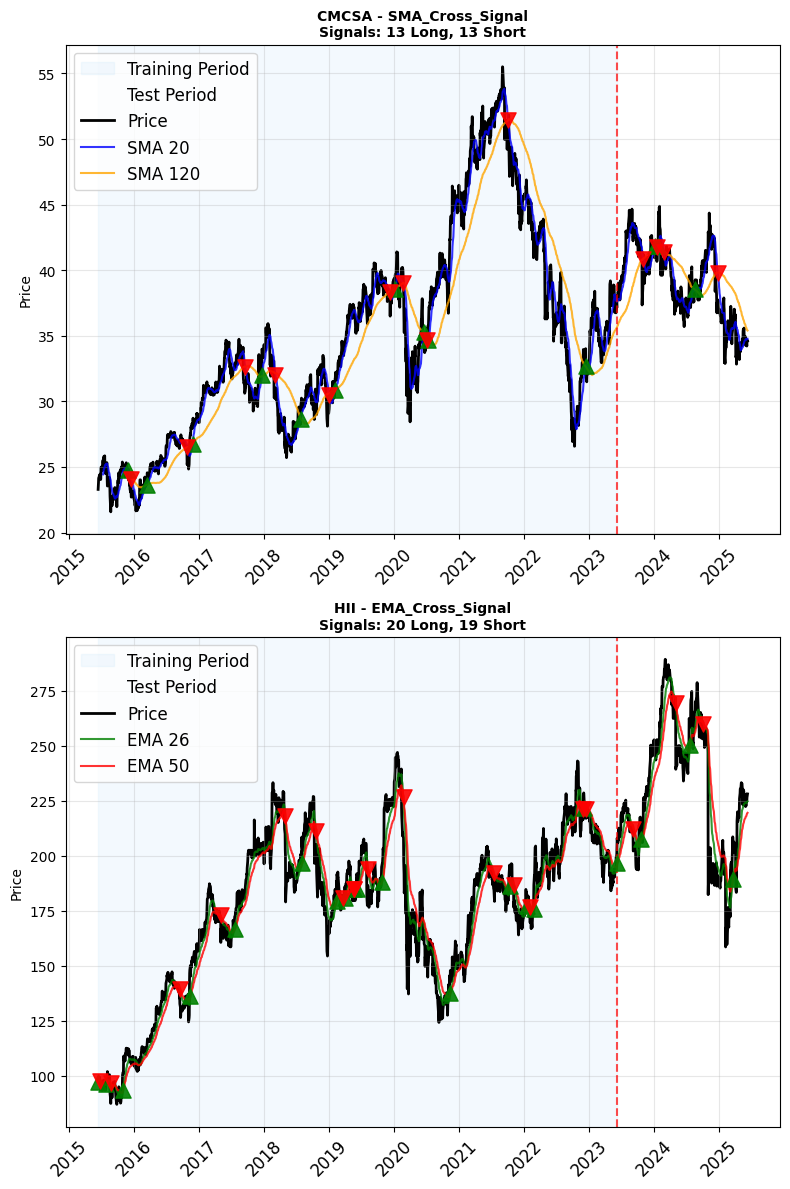

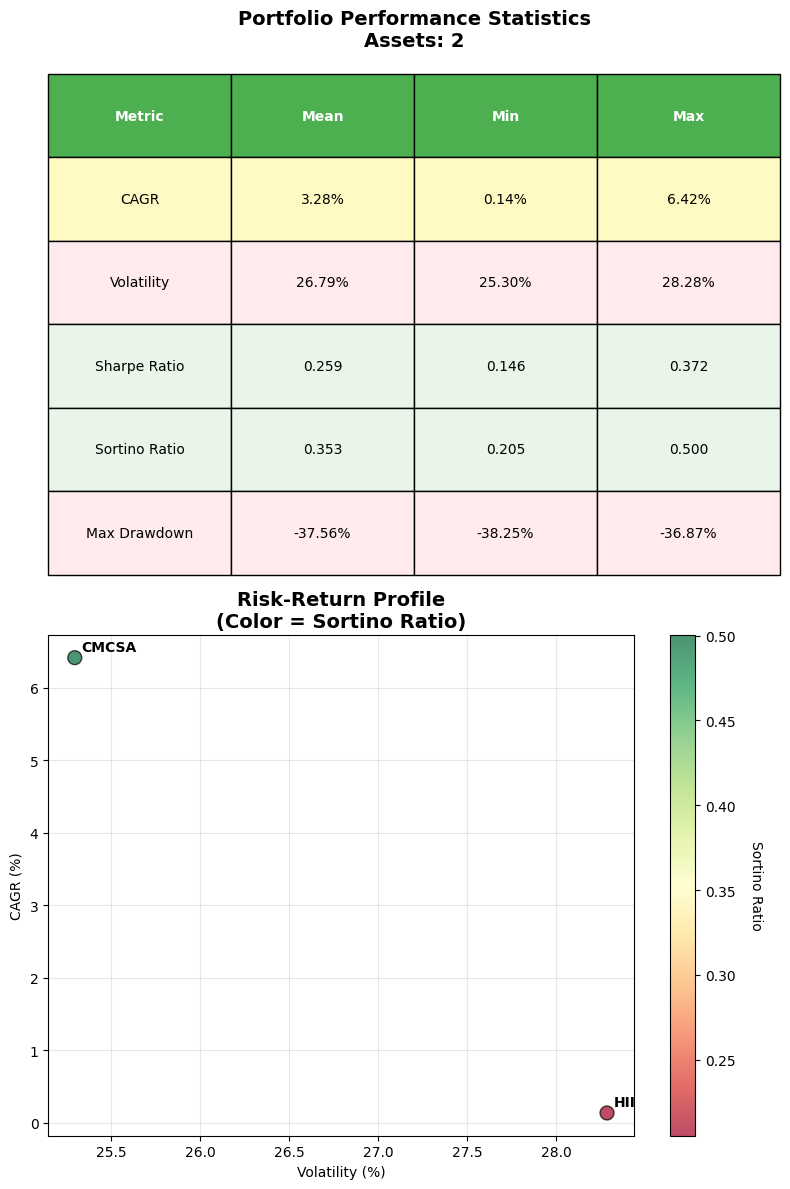

Selected tickers: ['CMCSA', 'HII']
Test set date range: 2023-06-07 00:00:00 to 2025-06-09 00:00:00
Portfolio test data shape: (503, 2)
Portfolio test data date range: 2023-06-07 00:00:00 to 2025-06-09 00:00:00
Final weights: {'CMCSA': 0.5, 'HII': 0.5}


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

Stat                 Short-Term Strategy
-------------------  ---------------------
Start                2023-06-06
End                  2025-06-09
Risk-free rate       4.24%

Total Return         4.30%
Daily Sharpe         0.02
Daily Sortino        0.03
CAGR                 2.12%
Max Drawdown         -30.48%
Calmar Ratio         0.07

MTD                  1.16%
3m                   4.54%
6m                   5.05%
YTD                  8.36%
1Y                   -4.71%
3Y (ann.)            2.12%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  2.12%

Daily Sharpe         0.02
Daily Sortino        0.03
Daily Mean (ann.)    4.61%
Daily Vol (ann.)     22.24%
Daily Skew           -1.19
Daily Kurt           13.90
Best Day             6.90%
Worst Day            -11.17%

Monthly Sharpe       -0.13
Monthly Sortino      -0.21
Monthly Mean (ann.)  1.64%
Monthly Vol (ann.)   18.97%
Monthly Skew         -0.36
Monthly Kurt         0.37
Best Month           9.89%
Worst Month       

<Axes: title={'center': 'Portfolio Performance on Test Set'}>

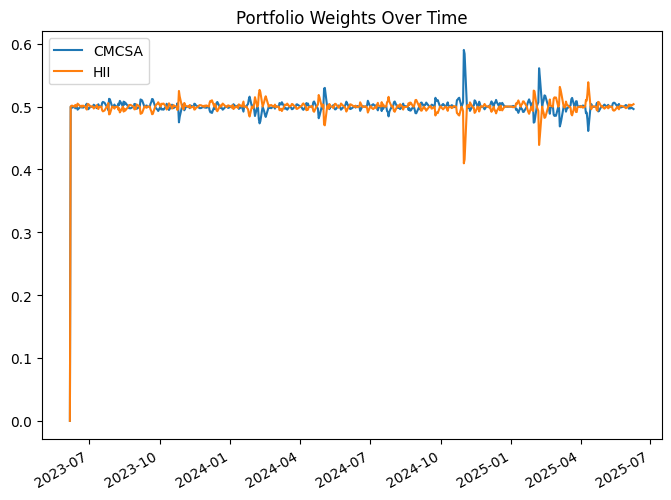

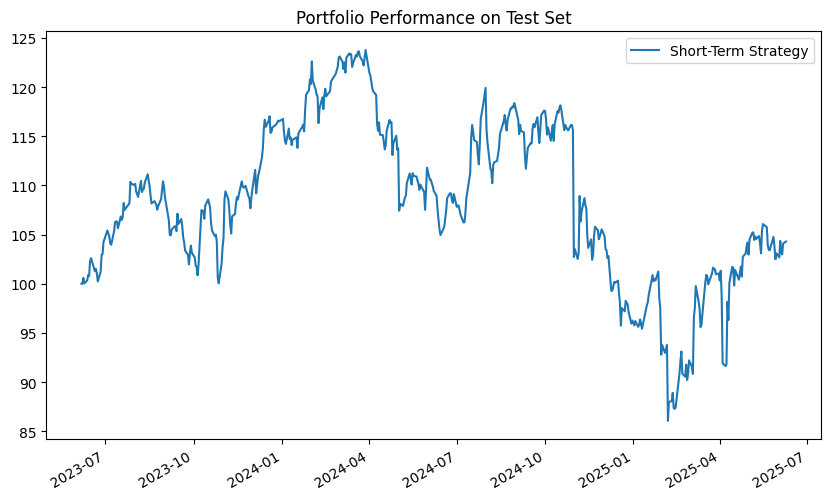

In [12]:
from py.technical_analysis import plot_portfolio_performance, plot_complete_strategy_analysis

# Generate and plot complete strategy analysis
plot_complete_strategy_analysis(optimization_results, quotes, training_set, test_set, cols=1)
plot_portfolio_performance(optimization_summary, cols=1, rows=2)

# Create portfolio weights and run backtest
portfolio_weights = optimization_results['portfolio_weights']
selected_tickers = optimization_results['selected_tickers']

print(f"Selected tickers: {selected_tickers}")
print(f"Test set date range: {test_set.index[0]} to {test_set.index[-1]}")

# Create a subset of quotes for selected tickers
portfolio_quotes = quotes[selected_tickers].dropna()
portfolio_test_data = portfolio_quotes.loc[test_set.index]

print(f"Portfolio test data shape: {portfolio_test_data.shape}")
print(f"Portfolio test data date range: {portfolio_test_data.index[0]} to {portfolio_test_data.index[-1]}")

# Handle portfolio_weights properly
if isinstance(portfolio_weights, pd.DataFrame):
    if len(portfolio_weights) == len(selected_tickers):
        weights_dict = {ticker: portfolio_weights.iloc[i, 0] for i, ticker in enumerate(selected_tickers)}
    else:
        weights_dict = {ticker: 1.0/len(selected_tickers) for ticker in selected_tickers}
elif isinstance(portfolio_weights, dict):
    weights_dict = {ticker: portfolio_weights.get(ticker, 1.0/len(selected_tickers)) for ticker in selected_tickers}
else:
    weights_dict = {ticker: 1.0/len(selected_tickers) for ticker in selected_tickers}

# Normalize weights to sum to 1
total_weight = sum(weights_dict.values())
if total_weight > 0:
    weights_dict = {k: v/total_weight for k, v in weights_dict.items()}

print(f"Final weights: {weights_dict}")

# Create and run portfolio backtest
portfolio_strategy = bt.Strategy('Short-Term Strategy', 
                 [
                     bt.algos.RunWeekly(),                 
                     bt.algos.SelectAll(),
                     bt.algos.WeighSpecified(**weights_dict),       
                     bt.algos.Rebalance()
                 ]
             )     

# Run backtest on the filtered test data
portfolio_backtest = bt.Backtest(portfolio_strategy, portfolio_test_data)
portfolio_result = bt.run(portfolio_backtest)

# Set risk-free rate
portfolio_result.set_riskfree_rate(risk_free_rate)

# Display results
portfolio_result.plot_security_weights(
    figsize=(8, 6),
    title='Portfolio Weights Over Time'
)

portfolio_result.display()
portfolio_result.plot(figsize=(10, 6), title='Portfolio Performance on Test Set')

#### 4: Statistical Test for Overfitting

In [13]:
from py.technical_analysis import run_overfitting_analysis

# Run comprehensive overfitting analysis
print("🔍 Analyzing Strategy for Overfitting...")
overfitting_analysis = run_overfitting_analysis(optimization_results, test_set)

# Extract key results
is_overfitted = overfitting_analysis['statistical_tests'].get('is_overfitted', False)
sharpe_p_value = overfitting_analysis['statistical_tests'].get('sharpe_p_value', 1.0)

if is_overfitted:
    print(f"\n⚠️ WARNING: Strategy may be overfitted (p-value: {sharpe_p_value:.4f})")
    print("Consider implementing the recommended improvements before deploying.")
else:
    print(f"\n✅ Good news: No significant overfitting detected (p-value: {sharpe_p_value:.4f})")
    print("Strategy appears robust for out-of-sample performance.")

🔍 Analyzing Strategy for Overfitting...
🔍 Running Overfitting Analysis...
📊 SUMMARY STATISTICS
Strategies tested: 2
In-sample mean Sharpe: 0.259
Out-sample mean Sharpe: -0.092
In-sample mean Sortino: 0.353
Out-sample mean Sortino: -0.143

📈 STATISTICAL TEST RESULTS
Sharpe t-statistic: 0.912
Sharpe p-value: 0.229
Sortino t-statistic: 0.899
Sortino p-value: 0.232

🎯 OVERFITTING STATUS: NOT DETECTED
   ✅ Sharpe ratio degradation not significant (p=0.229)
   ✅ Sortino ratio degradation not significant (p=0.232)

💡 RECOMMENDATIONS:
  ✅ NO SIGNIFICANT OVERFITTING: The strategy maintains reasonable performance from in-sample to out-of-sample testing.
  💡 Continue monitoring:
  • Track performance over time
  • Consider additional validation periods
  • Monitor parameter stability

📋 DETAILED TICKER ANALYSIS:

CMCSA:
  In-sample Sharpe: 0.372
  Out-sample Sharpe: -0.461
  Degradation: 223.8%
  Strategy: SMA_Cross_Signal
  Periods: 20/120

HII:
  In-sample Sharpe: 0.146
  Out-sample Sharpe: 0.2

#### 5: Walk-Forward Validation (Additional Robustness Check)

In [14]:
def walk_forward_validation(quotes_data, parameter_ranges, validation_periods=4):
    """
    Implement walk-forward optimization to reduce overfitting
    """
    from py.technical_analysis import find_optimal_portfolio_with_parameter_optimization
    
    total_length = len(quotes_data)
    period_length = total_length // validation_periods
    
    all_results = []
    
    for i in range(validation_periods - 1):  # Leave last period for final test
        # Training window
        train_start = i * period_length
        train_end = (i + 2) * period_length  # 2 periods for training
        
        # Test window
        test_start = train_end
        test_end = min(test_start + period_length, total_length)
        
        if test_end <= test_start:
            continue
            
        train_data = quotes_data.iloc[train_start:train_end]
        test_data = quotes_data.iloc[test_start:test_end]
        
        print(f"   Period {i+1}: Train {train_data.index[0]} to {train_data.index[-1]}")
        print(f"   Period {i+1}: Test {test_data.index[0]} to {test_data.index[-1]}")
        
        # Optimize on training period
        try:
            period_results = find_optimal_portfolio_with_parameter_optimization(
                quotes=train_data,
                max_stocks=2,
                n_jobs=2,  # Reduced for stability
                heatmap_metric='sharpe',
                parameter_ranges=parameter_ranges
            )
            
            # Test on validation period
            validation_analysis = run_overfitting_analysis(period_results, test_data)
            
            all_results.append({
                'period': i + 1,
                'train_sharpe': validation_analysis['summary']['in_sample_mean_sharpe'],
                'test_sharpe': validation_analysis['summary']['out_sample_mean_sharpe'],
                'is_overfitted': validation_analysis['statistical_tests']['is_overfitted'],
                'selected_tickers': period_results['selected_tickers']
            })
            
        except Exception as e:
            print(f"   ⚠️ Error in period {i+1}: {e}")
            continue
    
    return all_results

# Run walk-forward validation if overfitting detected
if is_overfitted:
    print("\n🔄 Running walk-forward validation (this may take a few minutes...)")
    wf_results = walk_forward_validation(quotes, parameter_ranges, validation_periods=4)
    
    # Analyze walk-forward results
    print("\n📊 WALK-FORWARD VALIDATION RESULTS:")
    print("-" * 50)
    stable_periods = 0
    total_periods = len(wf_results)
    
    for result in wf_results:
        status = "❌ OVERFITTED" if result['is_overfitted'] else "✅ STABLE"
        print(f"Period {result['period']}: {status}")
        print(f"  Train Sharpe: {result['train_sharpe']:.3f}")
        print(f"  Test Sharpe: {result['test_sharpe']:.3f}")
        print(f"  Tickers: {result['selected_tickers']}")
        
        if not result['is_overfitted']:
            stable_periods += 1
    
    stability_ratio = stable_periods / total_periods if total_periods > 0 else 0
    print(f"\n📈 STABILITY SUMMARY:")
    print(f"Stable periods: {stable_periods}/{total_periods} ({stability_ratio:.1%})")
    
    if stability_ratio >= 0.6:
        print("✅ Strategy shows reasonable stability across time periods")
    else:
        print("⚠️ Strategy remains unstable - consider further simplification")
else:
    print("\n✅ Skipping walk-forward validation - no overfitting detected")


✅ Skipping walk-forward validation - no overfitting detected


#### 6: Final Strategy Validation Summary

In [15]:
print("\n" + "="*60)
print("📋 FINAL STRATEGY VALIDATION SUMMARY")
print("="*60)

# Strategy assessment
if is_overfitted:
    print(f"🎯 STRATEGY STATUS: NEEDS IMPROVEMENT")
    print(f"Current Status: OVERFITTED (p-value: {sharpe_p_value:.4f})")
    print(f"\n⚠️ REQUIRED ACTIONS:")
    print(f"  1. ❌ Do not deploy current strategy")
    print(f"  2. 🔧 Review walk-forward validation results")
    print(f"  3. 📉 Further reduce parameter complexity")
    print(f"  4. 🎯 Focus on stable strategies only")
    print(f"  5. 📊 Consider longer out-of-sample testing")
else:
    print(f"🎯 STRATEGY STATUS: READY FOR DEPLOYMENT")
    print(f"✅ Passed overfitting tests (p-value: {sharpe_p_value:.4f})")
    print(f"\n💡 DEPLOYMENT RECOMMENDATIONS:")
    print(f"  1. ✅ Strategy appears robust")
    print(f"  2. 📊 Monitor performance closely")
    print(f"  3. 🎯 Consider paper trading first")
    print(f"  4. 📈 Set up regular re-optimization")
    print(f"  5. ⚖️ Implement risk management")

print(f"\n📊 STRATEGY METRICS:")
print(f"Selected tickers: {selected_tickers}")
print(f"Portfolio size: {len(selected_tickers)} stocks")
print(f"Training Sharpe: {overfitting_analysis['summary']['in_sample_mean_sharpe']:.3f}")
print(f"Testing Sharpe: {overfitting_analysis['summary']['out_sample_mean_sharpe']:.3f}")
print(f"Risk-free rate: {risk_free_rate:.3%}")


📋 FINAL STRATEGY VALIDATION SUMMARY
🎯 STRATEGY STATUS: READY FOR DEPLOYMENT
✅ Passed overfitting tests (p-value: 0.2289)

💡 DEPLOYMENT RECOMMENDATIONS:
  1. ✅ Strategy appears robust
  2. 📊 Monitor performance closely
  3. 🎯 Consider paper trading first
  4. 📈 Set up regular re-optimization
  5. ⚖️ Implement risk management

📊 STRATEGY METRICS:
Selected tickers: ['CMCSA', 'HII']
Portfolio size: 2 stocks
Training Sharpe: 0.259
Testing Sharpe: -0.092
Risk-free rate: 4.240%


### Step 8: Merge Strategy with Fundamental + Sentiment Analysis Data

In [16]:
from py.utils import clean_column_names

# Create a DataFrame with tickers and merge with optimization_summary
optimization_summary_with_tickers = optimization_summary.copy()
optimization_summary_with_tickers['Ticker'] = [ticker.upper() for ticker in selected_tickers]

# Convert to Polars for merging
best_strategies_pl = pl.DataFrame(optimization_summary_with_tickers)

# Prepare comprehensive_screened for merging - select only needed columns
comprehensive_screened_for_merge = comprehensive_screened.select([
    'symbol',
    'articlesInLastWeek',
    'companyNewsScore', 
    'bearishPercent',
    'bullishPercent',
    'averageSentimentScore',
    'sectorAverageBullishPercent',
    'sectorAverageNewsScore'
]).with_columns(
    pl.col("symbol").str.to_uppercase().alias("Ticker")
).drop('symbol')

# Chain all merges together
short_term_portfolio_pl = (fundamentals_df
    .join(best_strategies_pl, on='Ticker', how='inner')
    .join(comprehensive_screened_for_merge, on='Ticker', how='inner')
)

# Convert back to pandas for further processing
short_term_portfolio_df = short_term_portfolio_pl.to_pandas()
short_term_portfolio_df = short_term_portfolio_df.set_index('Ticker').sort_index()
short_term_portfolio_df = clean_column_names(short_term_portfolio_df)

# Add weights based on Sharpe Ratio
if 'sharpe_ratio' in short_term_portfolio_df.columns:
    # Normalize Sharpe ratios to create weights
    sharpe_sum = short_term_portfolio_df['sharpe_ratio'].sum()
    short_term_portfolio_df['Weight'] = short_term_portfolio_df['sharpe_ratio'] / sharpe_sum
else:
    # Fallback to equal weights if Sharpe ratio not available
    short_term_portfolio_df['Weight'] = 1.0 / len(short_term_portfolio_df)

# Verify weights sum to 1
print(f"Total portfolio weight: {short_term_portfolio_df['Weight'].sum():.6f}")

display(short_term_portfolio_df)

Total portfolio weight: 1.000000


,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,Shares Outstanding,...,Short Period,Long Period,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score,Weight
Ticker,,,,,,,,,,,,,,,,,,,,,
CMCSA,2025-06-11,Comcast Corporation,Communication Services,Telecom Services,United States,https://corporate.comcast.com,1.325464e+11,2.241855e+11,3.695023e+09,3.724260e+09,...,20,120,6,0.6130,0.0,0.6667,0.2259,0.4786,0.5623,0.5
HII,2025-06-11,"Huntington Ingalls Industries, Inc.",Industrials,Aerospace & Defense,United States,https://www.hii.com,8.728542e+09,1.200110e+10,3.896799e+07,3.923910e+07,...,26,50,5,0.6273,0.0,1.0000,0.2545,0.5117,0.5668,0.5


### Step 9: Export Portfolio to Excel

#### Prepare DataFrame for Export

In [17]:
# Merge Portfolio Daily Quotes with risk-free rate
daily_prices_df_merged = quotes[selected_tickers].join(daily_risk_free_df, how='inner')

# Convert all column names to uppercase
daily_prices_df_merged.columns = daily_prices_df_merged.columns.str.upper()

# Create a Monthly Price DataFrame
monthly_prices_df_merged = daily_prices_df_merged.copy()

# Make sure index is datetime
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to monthly (start of month) and get the last value
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

# Set Index to Date
monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True))

,CMCSA,HII,^IRX
Date,,,
2025-06-01,34.60,228.07,4.240
2025-05-01,34.57,223.06,4.230
2025-04-01,34.20,230.34,4.190
2025-03-01,36.57,204.04,4.190
2025-02-01,35.56,175.58,4.193
...,...,...,...
2015-10-01,25.20,100.31,0.068
2015-09-01,22.80,89.61,0.005
2015-08-01,22.58,94.15,0.003


#### Export DataFrame to Excel

In [18]:
from py.utils import export_to_excel

export_to_excel(output_file, {
    'short_term_portfolio': short_term_portfolio_df,
    'daily_quotes': daily_prices_df_merged,  
    'monthly_quotes': monthly_prices_df_merged   
})

print(f"\n✅ Portfolio exported successfully to: {output_file}")
print(f"📊 Selected tickers: {selected_tickers}")
print(f"💼 Portfolio size: {len(short_term_portfolio_df)} stocks")

# Final summary
print(f"\n🎯 FINAL PORTFOLIO SUMMARY:")
print(f"Strategy validation: {'⚠️ NEEDS REVIEW' if is_overfitted else '✅ VALIDATED'}")
print(f"Overfitting p-value: {sharpe_p_value:.4f}")
print(f"Portfolio weights: {dict(zip(selected_tickers, short_term_portfolio_df['Weight'].values))}")

Updated sheet 'short_term_portfolio'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-06-10.xlsx

✅ Portfolio exported successfully to: portfolios/portfolio-2025-06-10.xlsx
📊 Selected tickers: ['CMCSA', 'HII']
💼 Portfolio size: 2 stocks

🎯 FINAL PORTFOLIO SUMMARY:
Strategy validation: ✅ VALIDATED
Overfitting p-value: 0.2289
Portfolio weights: {'CMCSA': 0.5, 'HII': 0.5}
